In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import gc
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
data_types_dict ={
    'user_id': 'int32', 
    'timestamp': 'int64',
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [3]:
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [4]:
debug = False
if debug:
    nrows =300 * 10000
else:
    nrows = None

In [5]:
train_df = dt.fread(dir_path+file_train,max_nrows=nrows,columns = set(data_types_dict.keys())).to_pandas()

In [6]:
print('Training dataset detailed information')
print('*' * 50)
print('Columns:', train_df.columns)
print('*' * 50)
print('Shape:', train_df.shape)
print('*' * 50)
print('NA values in each column:', sum(train_df.isna().sum()))
print('*' * 50)

Training dataset detailed information
**************************************************
Columns: Index(['timestamp', 'user_id', 'content_id', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')
**************************************************
Shape: (101230332, 6)
**************************************************
NA values in each column: 2744044
**************************************************


In [7]:
# 获取target 非 -1的样本
train_df = train_df[train_df[target]!=-1].reset_index(drop=True,inplace=False)
# 用False填充nan
train_df['prior_question_had_explanation'].fillna(False,inplace=True)
train_df = train_df.astype(data_types_dict)

In [8]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
# 列方向上求累积和 和累积个数
cum = train_df.groupby('user_id')['lag'].agg(['cumsum','cumcount'])
# 学习进步的增长率
train_df['user_correctness'] = cum['cumsum']/cum['cumcount']
train_df.drop(columns=['lag'],inplace=True)

In [9]:
def clear_mem():
    %reset -f out
    %reset -f in
    gc.collect()
    
clear_mem()

Flushing output cache (1 entries)
Flushing input history


In [28]:
# overall correctness of users 用户回答问题正确的比例，数目和次数
# sum是回答正确的次数，count是回答的题目的总次数
user_agg = train_df.groupby('user_id')[target].agg(['sum','count'])
# overall difficulty of questions 每个content出现的次数和被回答正确的比例
content_agg = train_df.groupby('content_id')[target].agg(['sum','count'])
# 用户的最后一次答题时间
user_timestamp_agg = train_df.groupby(['user_id'])['timestamp'].tail()

In [11]:
# 只对每位用户进行10次最后观察
train_df = train_df.groupby('user_id').tail(10).reset_index(drop=True)

In [12]:
questions_df = pd.read_csv(
    dir_path + file_questions, 
    usecols = [0, 3],
    nrows=nrows,
    dtype = {'question_id': 'int16', 'part': 'int8'}
)

In [13]:
train_df.head()

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness
0,1359412,115,7897,0,17000.0,True,0.722222
1,1415188,115,7882,1,20000.0,True,0.702703
2,1468285,115,7962,1,17000.0,True,0.710526
3,667861680,115,1278,1,21000.0,False,0.717949
4,667971812,115,2065,1,17000.0,False,0.725000


In [14]:
train_df = pd.merge(train_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
train_df.drop(columns = ['question_id'], inplace = True)

In [15]:
# 某讲座被回答的次数
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')

#某讲座被回答的正确比例
train_df['content_corr'] = train_df['content_id'].map(content_agg('sum')/content_agg['count'])

In [16]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
# 用户是否看到上一个问题的答案，第一个题目为null。通常前几个都为false，因为是测试。
train_df['lag'] = train_df.groupby('user_id')['prior_question_had_explanation'].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum','cumcount']) # 看上一题解释的总数和列数。
train_df['explanation_mean'] = cum['cumsum']/cum['cumcount'] # 解释的平均
train_df['explanation_cumsum'] = cum['cumsum'] 

train_df.drop(columns=['lag'],inplace=True)

train_df['explanation_mean'].fillna(0,inplace=True)
train_df['explanation_cumsum'].fillna(0,inplace=True)
train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_cumsum=train_df.explanation_cumsum.astype('int16')

In [17]:
train_df

,timestamp,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count,explanation_mean,explanation_cumsum
0,1359412,115,7897,0,17000.0,1,0.722222,1,16284,0.00,0
1,1415188,115,7882,1,20000.0,1,0.702703,1,12643,1.00,1
2,1468285,115,7962,1,17000.0,1,0.710526,1,5853,1.00,2
3,667861680,115,1278,1,21000.0,0,0.717949,2,171098,1.00,3
4,667971812,115,2065,1,17000.0,0,0.725000,3,176043,0.75,3
...,...,...,...,...,...,...,...,...,...,...,...
3928406,428564420,2147482888,3586,1,18000.0,1,0.500000,5,4364,1.00,5
3928407,428585000,2147482888,6341,1,14000.0,1,0.521739,5,10220,1.00,6
3928408,428613475,2147482888,4212,1,14000.0,1,0.541667,5,31415,1.00,7
3928409,428649406,2147482888,6343,0,22000.0,1,0.560000,5,5752,1.00,8


In [18]:
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum','count'])
explanation_agg = explanation_agg.astype('int16')

In [19]:
max_timestampe_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestampe_u.columns = ['user_id','max_time_stamp'] 

train_df['lagtime']=train_df.groupby('user_id')['timestamp'].shift()
train_df['lagtime']=train_df['timestamp'] - train_df['lagtime'] #此用户交互与改用户完成第一个事件之间的时间(毫秒)

train_df['lagtime'].fillna(0,inplace=True)
train_df.lagtime = train_df.lagtime.astype('int32')

lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean']) # 完成每一题的平均时间
train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
train_df.lagtime_mean=train_df.lagtime_mean.astype('int32') # 转换数据格式

train_df['timestamp']=train_df['timestamp']/(1000*3600) #时间转换为小时
train_df.timestamp=train_df.timestamp.astype('int16')

In [20]:
# 提取验证集 3/10
valid_df = train_df.groupby('user_id').tail(3)
train_df.drop(valid_df.index,inplace=True)

In [21]:
features = [
    'timestamp',
    'lagtime',
    'lagtime_mean',
    'content_id',
    'content_corr',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

params = {
    'objective': 'binary',
}
lgb_train = lgb.Dataset(train_df[features], train_df[target])
lgb_eval = lgb.Dataset(valid_df[features], valid_df[target], reference=lgb_train)


evals_result = {}
NUM_BOOST_ROUNDS = 300

lgb_model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=25,
    num_boost_round=10000,
    early_stopping_rounds=100,
    evals_result=evals_result
)

[LightGBM] [Info] Number of positive: 1545489, number of negative: 1202188
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1791
[LightGBM] [Info] Number of data points in the train set: 2747677, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562471 -> initscore=0.251197
[LightGBM] [Info] Start training from score 0.251197
Training until validation scores don't improve for 100 rounds
[25]	training's binary_logloss: 0.626119	valid_1's binary_logloss: 0.640112
[50]	training's binary_logloss: 0.618574	valid_1's binary_logloss: 0.634083
[75]	training's binary_logloss: 0.615052	valid_1's binary_logloss: 0.630605
[100]	training's binary_logloss: 0.612921	valid_1's binary_logloss: 0.628373
[125]	training's binary_logloss: 0.611165	valid_1's binary_logloss: 0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

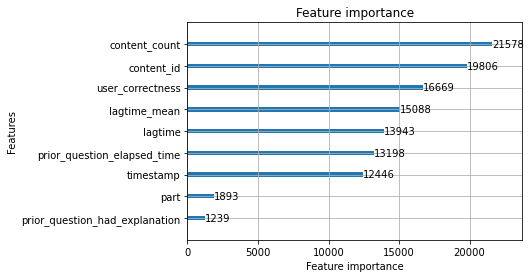

In [25]:
lgb.plot_importance(lgb_model)

In [29]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
#     'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
    'grow_policy': 'Lossguide',
    'iterations': 2500,
    'learning_rate': 0.07,
    'random_seed': 0,
    'l2_leaf_reg': 1e-1,
    'depth': 15,
    'max_leaves': 10,
    'border_count': 128,
    'verbose': 50,
}
import catboost
from catboost import CatBoostClassifier, Pool

# Training and validating data
train_set = Pool(train_df[features], label = train_df[target])
val_set = Pool(valid_df[features], label = valid_df[target])

# Model definition
model = CatBoostClassifier(**params)

# Fitting
model.fit(train_set, eval_set = val_set, use_best_model = True)

0:	test: 0.6202260	best: 0.6202260 (0)	total: 1.34s	remaining: 55m 40s
50:	test: 0.6789494	best: 0.6789494 (50)	total: 55.3s	remaining: 44m 13s
100:	test: 0.6861847	best: 0.6861847 (100)	total: 1m 50s	remaining: 43m 35s
150:	test: 0.6892076	best: 0.6892076 (150)	total: 2m 44s	remaining: 42m 35s
200:	test: 0.6915842	best: 0.6916092 (199)	total: 3m 38s	remaining: 41m 43s
250:	test: 0.6938232	best: 0.6938232 (250)	total: 4m 33s	remaining: 40m 48s
300:	test: 0.6950908	best: 0.6950908 (300)	total: 5m 26s	remaining: 39m 46s
350:	test: 0.6968114	best: 0.6968357 (349)	total: 6m 19s	remaining: 38m 45s
400:	test: 0.6981134	best: 0.6981398 (399)	total: 7m 11s	remaining: 37m 36s
450:	test: 0.6993855	best: 0.6993855 (450)	total: 8m 2s	remaining: 36m 30s
500:	test: 0.7003092	best: 0.7003092 (500)	total: 8m 52s	remaining: 35m 25s
550:	test: 0.7011213	best: 0.7011213 (550)	total: 9m 43s	remaining: 34m 22s
600:	test: 0.7020037	best: 0.7020037 (600)	total: 10m 34s	remaining: 33m 23s
650:	test: 0.7027657